# Problem Statement

In this assignment students have to compress racoon grey scale image into 5 clusters. In the end, visualize both raw and compressed image and look for quality difference. The raw image is available in spicy.misc package with the name face.


In [1]:
%matplotlib inline


# Segmenting the picture of a raccoon face in regions


This example uses `spectral_clustering` on a graph created from
voxel-to-voxel difference on an image to break this image into multiple
partly-homogeneous regions.

This procedure (spectral clustering on an image) is an efficient
approximate solution for finding normalized graph cuts.

There are two options to assign labels:

* with 'kmeans' spectral clustering will cluster samples in the embedding space
  using a kmeans algorithm
* whereas 'discrete' will iteratively search for the closest partition
  space to the embedding space.



# Compress racoon grey scale image into 5 clusters using Sklearn Spectral Clustering Api

In [2]:

import time

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering


# load the raccoon face as a numpy array
try:  # SciPy >= 0.16 have face in misc
    from scipy.misc import face
    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)

# Resize it to 10% of the original size to speed up the processing
face = sp.misc.imresize(face, 0.10) / 255.

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(face)

# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
beta = 5
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

print(type(graph))
print(graph.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(7752, 7752)


C:\Users\Sashsam\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


# Visualize the resulting regions



(7752,)
(76, 102)
[0 1 2 3 4]
Spectral clustering: kmeans, 5.43s
(7752,)
(76, 102)
[0 1 2 3 4]
Spectral clustering: discretize, 5.42s


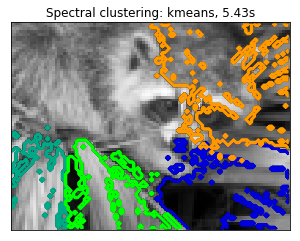

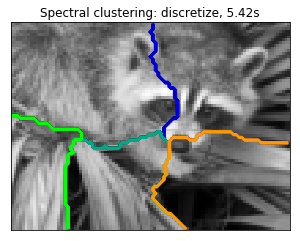

In [31]:
import time
N_REGIONS = 5
for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=N_REGIONS,
                                 assign_labels=assign_labels, random_state=1)
    t1 = time.time()
    print(labels.shape)
    labels = labels.reshape(face.shape)
    print(labels.shape)
    print(np.unique(labels))
    plt.figure(figsize=(5, 5))
    plt.imshow(face, cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, contours=1,
                    colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    title = 'Spectral clustering: %s, %.2fs' % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
plt.show()

# Clustering using K Means Algorithm - Kmeans sklearn Api

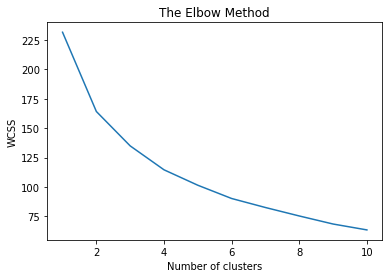

labels generated :
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4
 4 4 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


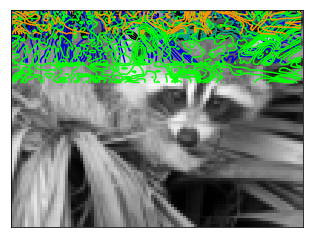

In [44]:
from sklearn.cluster import KMeans


n_clusters = 5
np.random.seed(0)
X = face
wcss=[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


#face = sp.misc.imresize(face, 0.10) / 255.
X =face
k_means = KMeans(n_clusters=5,random_state=0,init='k-means++')
k_means.fit(X)
labels = k_means.labels_
print("labels generated :\n",labels)
N_REGIONS =5
#labels = labels.reshape(face.shape)
#print(labels.reshape(-1,102))
#plt.figure(figsize=(5, 5))
plt.imshow(face, cmap=plt.cm.gray)
for l in range(N_REGIONS):
    plt.contour(X[labels == l], contours=1,colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
plt.xticks(())
plt.yticks(())
plt.show()

# Spectaral Clustering using similarity distance matrix, Degree diagonal matrix, Laplacian matrix

In [14]:
import numpy as np
from scipy import linalg as LA
var = 1.5
k = 5
def RbfKernel(data1, data2, sigma):
    delta =np.matrix(abs(np.subtract(data1, data2)))
    squaredEuclidean = (np.square(delta).sum(axis=1))
    result = np.exp(-(squaredEuclidean)/(2*sigma**2))
    return result

def buildSimmilarityMatrix(dataIn):
    nData = dataIn.shape[0]
    result = np.matrix(np.full((nData,nData), 0, dtype=np.float))
    for i in range(0,nData):
        for j in range(0, nData):
            weight = RbfKernel(dataIn[i, :], dataIn[j, :], var)
            result[i,j] = weight
    return result

def buildDegreeMatrix(similarityMatrix):
    diag = np.array(similarityMatrix.sum(axis=1)).ravel()
    result = np.diag(diag)
    return result

def unnormalizedLaplacian(simMatrix, degMatrix):
    result = degMatrix - simMatrix
    return result

def transformToSpectral(laplacian):
    global k
    e_vals, e_vecs = LA.eig(np.matrix(laplacian))
    ind = e_vals.real.argsort()[:k]
    result = np.ndarray(shape=(laplacian.shape[0],0))
    for i in range(1, ind.shape[0]):
        cor_e_vec = np.transpose(np.matrix(e_vecs[:,np.asscalar(ind[i])]))
        result = np.concatenate((result, cor_e_vec), axis=1)
    return result

In [15]:
simMat = buildSimmilarityMatrix(face)
degMat = buildDegreeMatrix(simMat)
lapMat = unnormalizedLaplacian(simMat, degMat)
transformedData = transformToSpectral(lapMat)

In [17]:
transformedData.shape

(76, 4)

In [18]:
lapMat.shape

(76, 76)

In [21]:
simMat.shape

(76, 76)

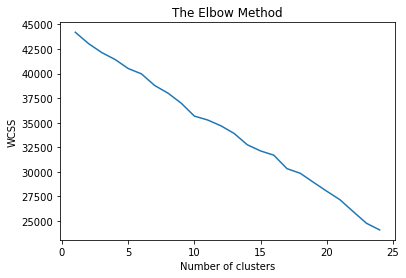

In [24]:
wcss=[]
for i in range(1,25):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(lapMat)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

labels generated :
 [1 1 2 1 0 1 1 1 3 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


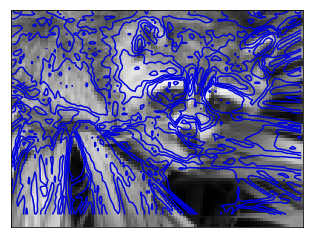

In [27]:
k_means = KMeans(n_clusters=5,random_state=0,init='k-means++')
k_means.fit(lapMat)
labels = k_means.labels_
print("labels generated :\n",labels)
N_REGIONS =5
#labels = labels.reshape(face.shape)
#print(labels.reshape(-1,102))
#plt.figure(figsize=(5, 5))
plt.imshow(face, cmap=plt.cm.gray)
for l in range(N_REGIONS):
    plt.contour(X[labels == l], contours=1,colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
plt.xticks(())
plt.yticks(())
plt.show()